# Tutorial: ACCorDIoN test data

*Note: Before using ACCorDIoN make sure that you have the CrossTalkeR installed in your local R enviroment*

CrossTalkeR object are read using the function 
```{python}
parse_CrossTalkeR("file_path/LR.Rds")
```

## Load Libraries

In [1]:
from accordion import pdac
from accordion.Accordion import Accordion 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pydiffmap as dm

#### 1. Loading data and metadata

In [2]:
data = pdac.load_peng2019()
pdata_metadata = pdac.load_peng2019_metadata()
pdata_metadata['label1'] = ['Normal Pancreas' if i.find('normal')>= 0 else 'PDAC' for i in pdata_metadata.accLabel]

#### 2. This are tables made by CrossTalkeR/Liana therefore we need to filter it to keep only the single(per sample) networks

In [3]:
data = {i:data[i] for i in data.keys()  if i.find("_x_") < 0 }

#### 3. Now with the tables from CrossTalkeR/Liana we build the Accordion Object 

In [4]:
AaccPDAC = Accordion(tbls=data,weight='lr_means')

#### 4. Computing a PCA using the edge distribuition per sample

In [5]:
AaccPDAC.make_pca()

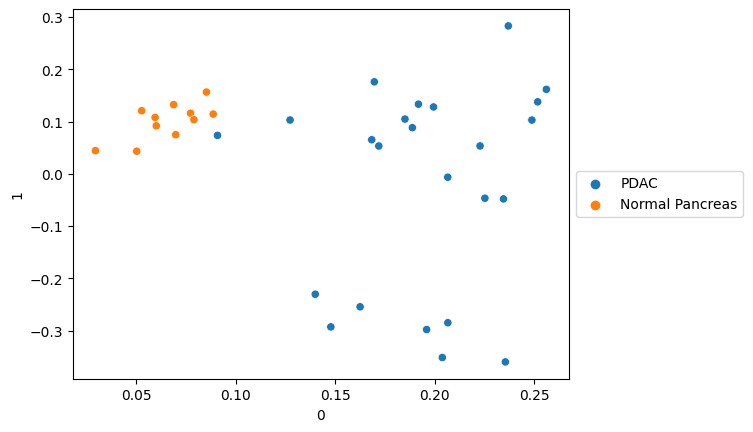

In [6]:
sns.scatterplot(x=0,y=1,data=AaccPDAC.Cs['PCA'],
                hue=pdata_metadata.loc[AaccPDAC.Cs['PCA'].index,'label1'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


#### 5. Normalizing the data $\mathcal{P}$

In [7]:
for i in AaccPDAC.p.columns:
    AaccPDAC.p[i] = AaccPDAC.p[i]/AaccPDAC.p[i].sum()

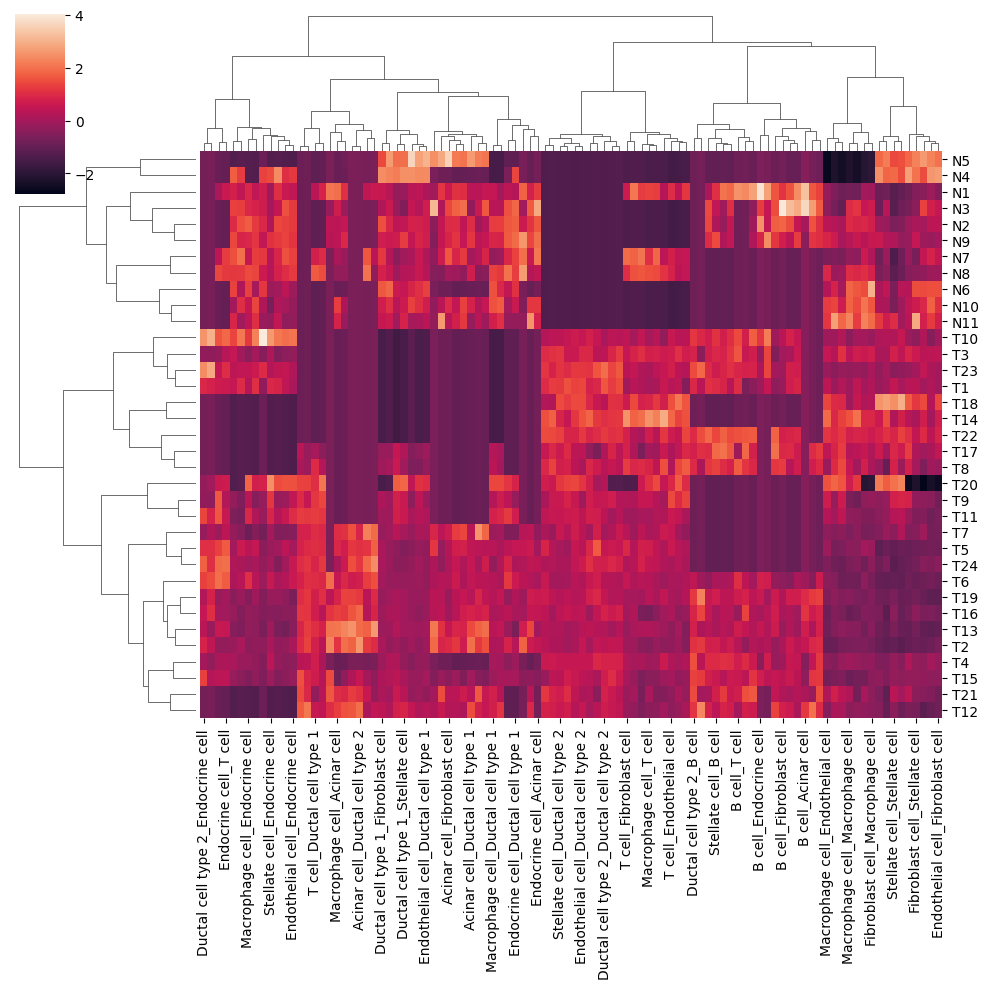

In [8]:
sns.clustermap(AaccPDAC.p.T,z_score=1,method='ward')

#### 6. Building the Cost Matrix

Here we can compute all possible default options of cost matrix, for the details please read our manuscript. For instance we gonna focus in the CTD cost matrix by now.

```{python}
AaccPDAC.compute_cost_all() ## Run all the possible cost matrices
```

In [9]:
AaccPDAC.compute_cost(mode='CTD')

/home/james/.local/lib/python3.10/site-packages/accordion/distances.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G,weight=weight).todense()


In [10]:
AaccPDAC.compute_wassestein(cost='CTD')

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 56.54it/s]


#### 6. Clustering the wasserstein distance matrix

In [11]:
twoclsm = KMeans(n_clusters=2)
aux = dm.diffusion_map.DiffusionMap.from_sklearn(metric='precomputed',
                                                 n_evecs = 2, 
                                                 epsilon =1, 
                                                 alpha = 0.5, 
                                                 k=64)
aux = aux.fit_transform(AaccPDAC.wdist['CTD'])

Text(0.5, 1.0, 'Original Labels')

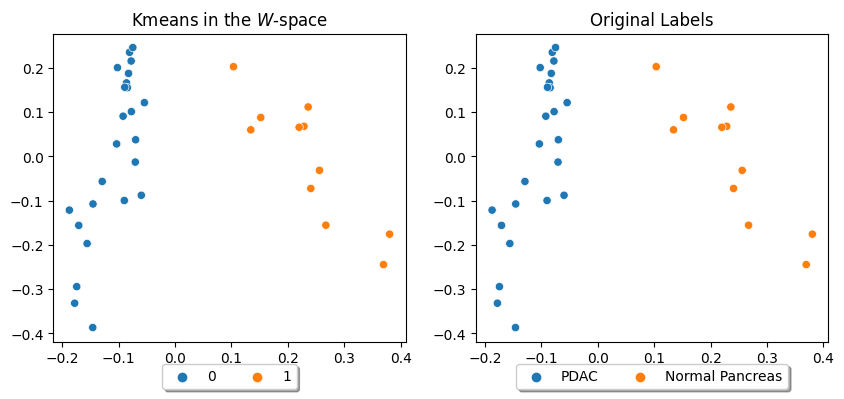

In [12]:
_,ax1 = plt.subplots(1,2,figsize=(10,4))
ax1 = ax1.ravel()
sns.scatterplot(x=aux[:,0],y=aux[:,1],hue=twoclsm.fit_predict(AaccPDAC.wdist['CTD']),ax=ax1[0]) 
ax1[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax1[0].set_title('Kmeans in the $W$-space')
sns.scatterplot(x=aux[:,0],y=aux[:,1],hue=pdata_metadata.loc[AaccPDAC.Cs['PCA'].index,'label1'],ax=ax1[1])
ax1[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax1[1].set_title('Original Labels')


In [13]:
threeclsm = KMeans(n_clusters=3)
threeclsm = threeclsm.fit_predict(AaccPDAC.wdist['CTD'])

Text(0.5, 1.0, 'Original Labels')

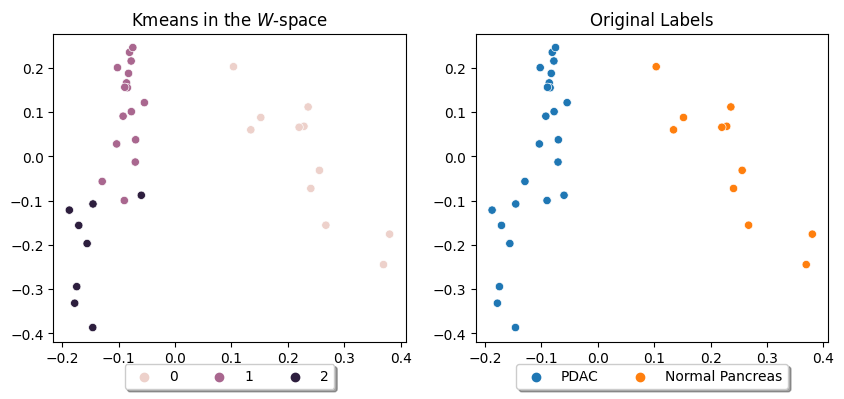

In [14]:
_,ax1 = plt.subplots(1,2,figsize=(10,4))
ax1 = ax1.ravel()
sns.scatterplot(x=aux[:,0],y=aux[:,1],hue=threeclsm,ax=ax1[0]) 
ax1[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax1[0].set_title('Kmeans in the $W$-space')
sns.scatterplot(x=aux[:,0],y=aux[:,1],hue=pdata_metadata.loc[AaccPDAC.Cs['PCA'].index,'label1'],ax=ax1[1])
ax1[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
ax1[1].set_title('Original Labels')


#### 7. Explaining our clusters

In [15]:
pdata_metadata.loc[AaccPDAC.p.columns,'cls'] = threeclsm

<Figure size 640x480 with 0 Axes>

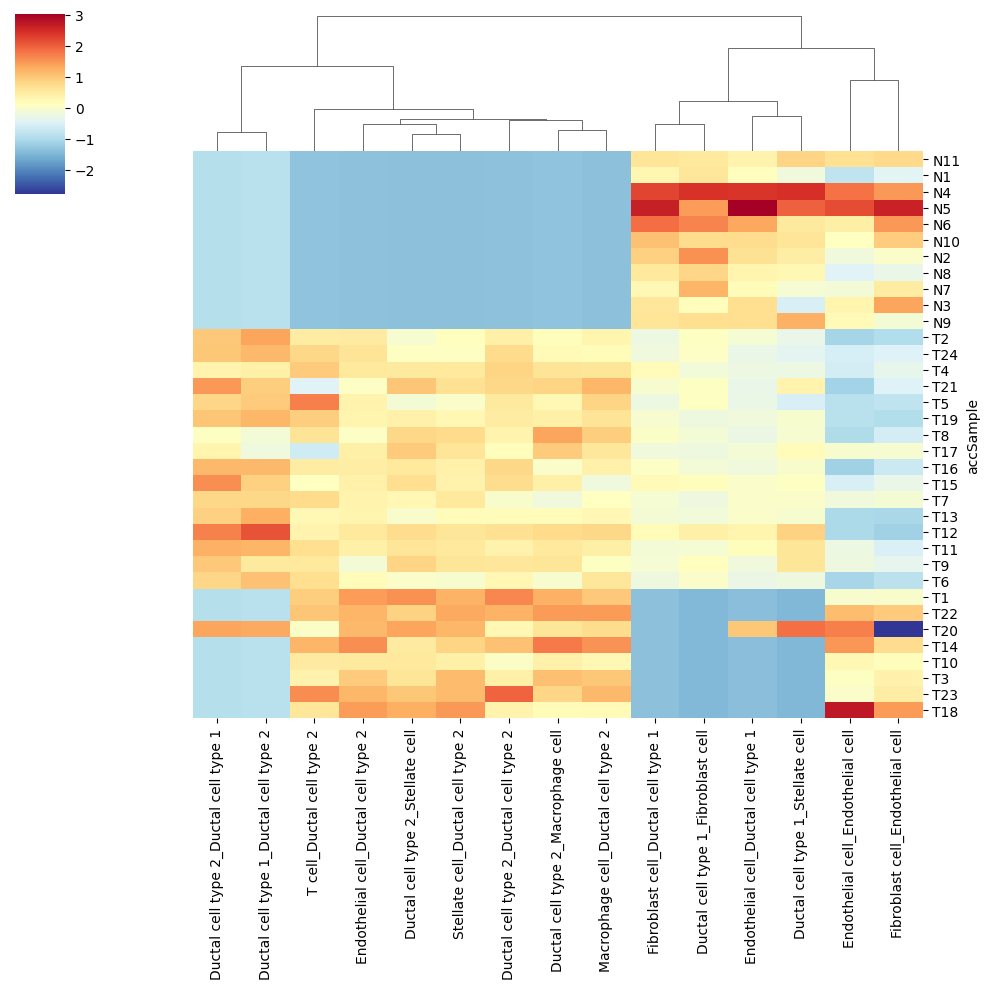

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
import numpy as np
regr = RandomForestClassifier(max_depth=2, random_state=0)
edist = AaccPDAC.p.T
regr.fit(edist, threeclsm)
sel =AaccPDAC.p.iloc[np.argsort(regr.feature_importances_)[::-1][0:15],]
plt.figure()
sns.clustermap(sel.T.loc[pdata_metadata.sort_values(by='cls').index,:],
            cmap='RdYlBu_r',row_cluster=False,z_score=1)
plt.show()

####  8. Features per Samples

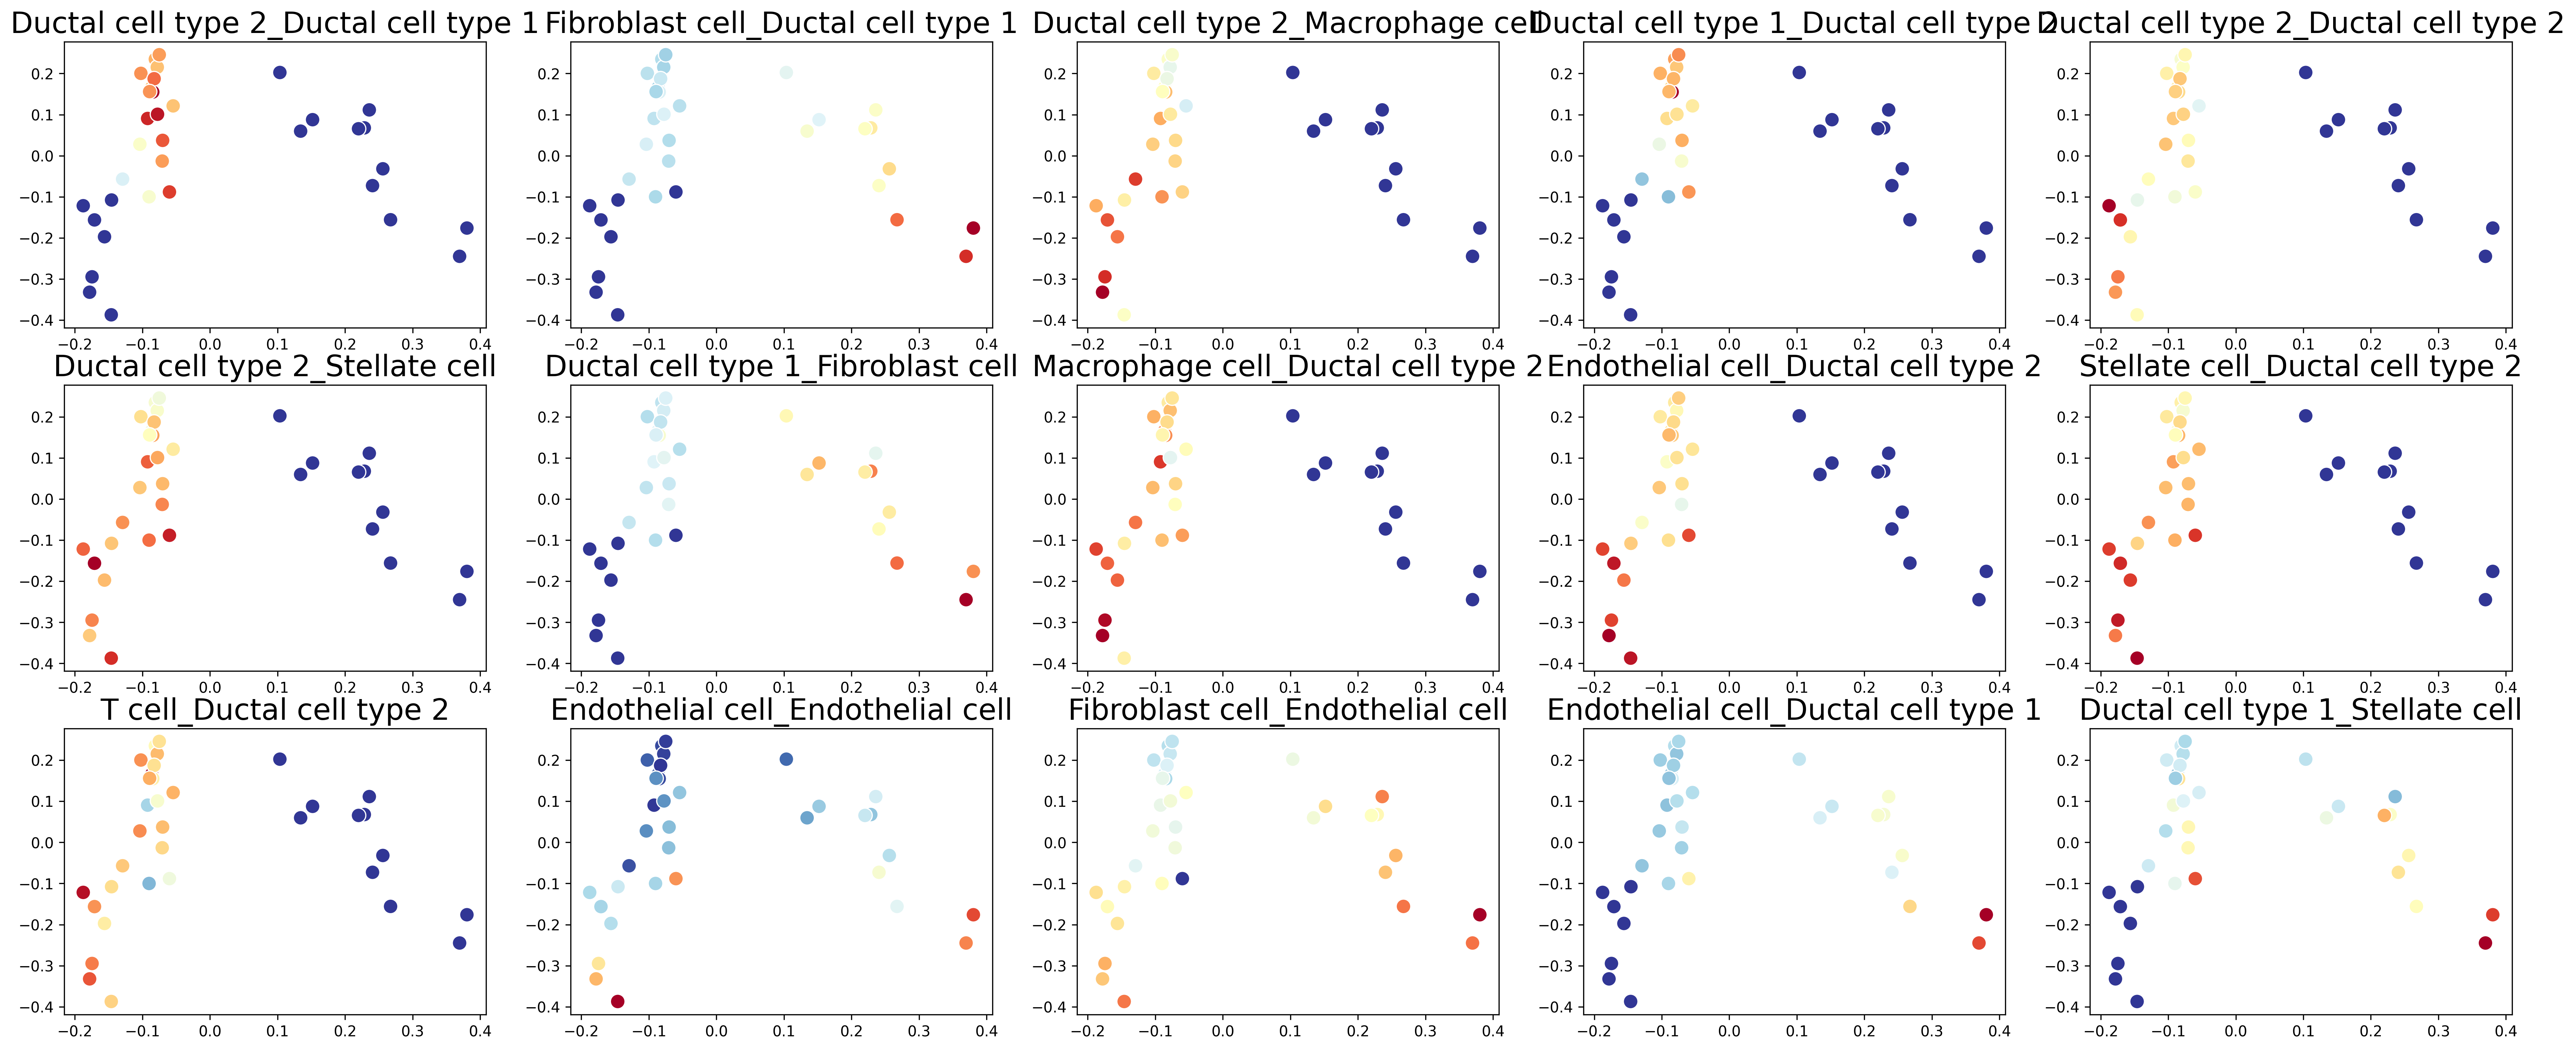

In [17]:
fig2,ax2 = plt.subplots(3,5,figsize=(30,12),dpi=300)
ax2 = ax2.ravel()
it=regr.feature_names_in_[np.argsort(regr.feature_importances_)[::-1][0:15]]
for idi, i in enumerate(it):
    sns.scatterplot(x=aux[:,0],
                    y=aux[:,1],
                    hue=edist.T.loc[i,],
                    ax=ax2[idi],legend=False,palette='RdYlBu_r',s=100)
    ax2[idi].set_title(f"{i}",fontdict={"fontsize":20})
